In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import re
import string
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and preprocessing
import nltk

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay
)

# Deep learning & transformers
import torch
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Azure OpenAI
from openai import AzureOpenAI

# Progress bar
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/NLP Project/data/combined_dataset.csv'
df = pd.read_csv(file_path)

# Show the first few rows
df.head()

,text,label,dataset
0,Intravenous azithromycin-induced ototoxicity.,1,ade_classification_dataset
1,"Immobilization, while Paget's bone disease was...",1,ade_classification_dataset
2,Unaccountable severe hypercalcemia in a patien...,1,ade_classification_dataset
3,METHODS: We report two cases of pseudoporphyri...,1,ade_classification_dataset
4,METHODS: We report two cases of pseudoporphyri...,1,ade_classification_dataset


In [ ]:
# Print dataset shape
print(f"Shape of dataset: {df.shape}\n")

# Create summary table
summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum().values,
    'Data Type': df.dtypes.values
})

# Display table
summary

Shape of dataset: (29525, 3)



,Column,Missing Values,Data Type
0,text,1,object
1,label,0,int64
2,dataset,0,object


In [ ]:
df["dataset"].value_counts()

,count
dataset,
ade_classification_dataset,23516
PsyTAR_dataset,6009


In [ ]:
# How many 0 and 1 labels does ade_classification_dataset have
df[df["dataset"] == "ade_classification_dataset"]["label"].value_counts()

,count
label,
0,16695
1,6821


In [ ]:
# How many 0 and 1 labels does PsyTAR_dataset have
df[df["dataset"] == "PsyTAR_dataset"]["label"].value_counts()

,count
label,
0,3841
1,2168


First, we checked the columns, their data types, and whether there were any missing values. The 'text' column had one missing value, which will be addressed later. Then, we examined the distribution of labels (0 and 1) in our two datasets: ADE Classification and PsyTAR. ADE contains 16,695 non-ADR and 6,821 ADR texts, while PsyTAR has 3,841 non-ADR and 2,168 ADR texts.

### Checking for missing:

In [ ]:
df[df['text'].isna()]

,text,label,dataset
24358,NaN,0,PsyTAR_dataset


In [ ]:
# Dropping the missing column
df = df.dropna(subset=['text']).reset_index(drop=True)

We dropped the row with the missing text value since it didn't give us any information.

### Checking for duplicates:

In [ ]:
# Display how text column looks
df['text'].value_counts()

,count
text,
"A 27-year-old man who had a history of bronchial asthma, eosinophilic enteritis, and eosinophilic pneumonia presented with fever, skin eruptions, cervical lymphadenopathy, hepatosplenomegaly, atypical lymphocytosis, and eosinophilia two weeks after receiving trimethoprim (TMP)-sulfamethoxazole (SMX) treatment.",24
"CASE SUMMARY: A 65-year-old patient chronically treated with the selective serotonin reuptake inhibitor (SSRI) citalopram developed confusion, agitation, tachycardia, tremors, myoclonic jerks and unsteady gait, consistent with serotonin syndrome, following initiation of fentanyl, and all symptoms and signs resolved following discontinuation of fentanyl.",21
A case report.,21
"CONCLUSION: The new quinolone derivatives (levofloxacin, sparfloxacin, grepafloxacin, trovafloxacin, gatifloxacin and moxifloxacin), also called gyrase inhibitors, are known for their potential to cause central nervous system-related adverse effects, including headache, dizziness and insomnia.",18
"Rapamycin/sirolimus (SR), trade named Rapammune (Wyeth-Ayerst, Sydney, Australia), is a potent immunosuppressive drug associated with myelosuppression, hypertension, hyperlipidemia, and infection.",16
...,...
"We present a report of B. henselae infection transmitted by the same kitten to 4 different individuals, each with different clinical characteristics, treatment, and evolution.",1
Successful treatment was achieved with partial resection of the posterior mitral valve leaflet and antibiotic therapy.,1
"The pathogenesis of the porphyria is not clear; however, cyclophosphamide is a substrate for cytochrome P450, and may produce metabolites that destroy this protein.",1


We can already see duplicates here.

In [ ]:
# Check number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 2639


In [ ]:
# Drop duplicate rows and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Check shape after removal
print(f"New shape after dropping duplicates: {df.shape}")

New shape after dropping duplicates: (26885, 3)


In [ ]:
print("Unique labels:", df['label'].unique())
print("Number of unique texts:", df['text'].nunique())

Unique labels: [1 0]
Number of unique texts: 26885


In [ ]:
df["dataset"].value_counts()

,count
dataset,
ade_classification_dataset,20896
PsyTAR_dataset,5989


After removing 2,639 duplicate rows, the combined dataset contains 20,896 sentences from the ade_classification_dataset and 5,989 from the PsyTAR_dataset - a total of 26,885 unique texts. Most of the data comes from the ADE dataset.

### Label Distribution:

In [ ]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,20450,76.06
1,1,6435,23.94


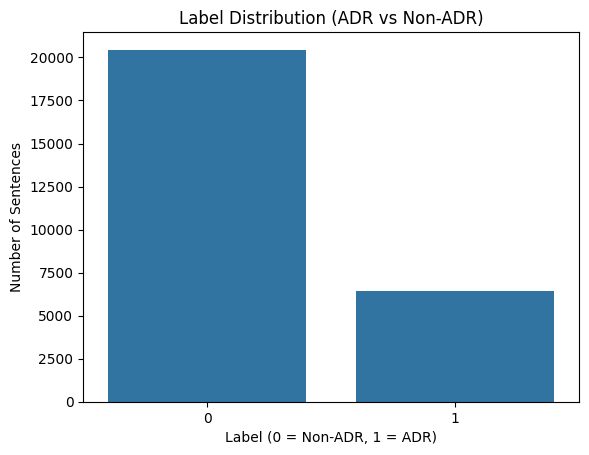

In [ ]:
# Plot label distribution
sns.countplot(x='label', data=df)
plt.title('Label Distribution (ADR vs Non-ADR)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Sentences')
plt.show()

The dataset shows a clear class imbalance, with ~76% non-ADR sentences and ~24% ADR sentences. This imbalance will be considered during model training and evaluation.

In [ ]:
# Calculate sentence lengths
sentence_lengths = df['text'].apply(lambda x: len(str(x).split()))

# Get sentence length stats as DataFrame
sentence_stats = sentence_lengths.describe().round(2).to_frame().T

# Display
sentence_stats

,count,mean,std,min,25%,50%,75%,max
text,26885.0,17.21,8.95,1.0,11.0,16.0,22.0,156.0


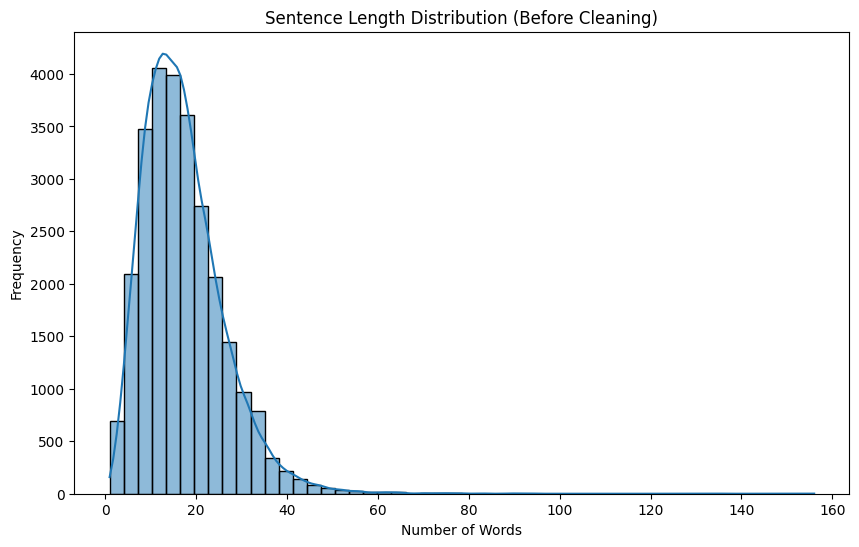

In [ ]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Sentence Length Distribution (Before Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

We analyzed the distribution of sentence lengths in the ADE dataset (measured in word count per sentence). The dataset contains 26,885 sentences (after duplicates + missing removal), with an average length of approximately 17.21 words (SD = 8.95). The shortest sentence contains 1 word, while the longest reaches 156 words. The 25th percentile is at 11 words, the median at 16 words, and the 75th percentile at 22 words. These results show that while most sentences are relatively short, some are significantly longer. This variation in length may affect model performance, particularly in tasks involving sentence embeddings or prompt-based inference, due to potential issues like truncation or processing inefficiencies.

### Checking Which Label Has Longer Sentences:

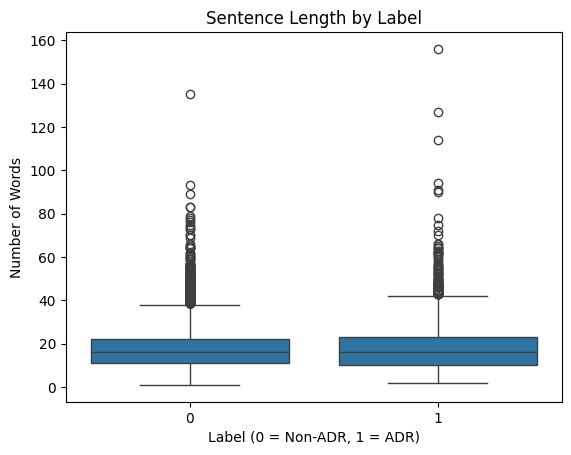

In [ ]:
sns.boxplot(x='label', y=sentence_lengths, data=df)
plt.title('Sentence Length by Label')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

We visualized the sentence length distribution by label (ADR vs Non-ADR) before text cleaning. The plot shows that sentences labeled as ADR (1) are slightly longer on average than Non-ADR (0), with a marginally higher median and more high-end outliers. While the overall distributions are quite similar, the presence of longer ADR sentences suggests they may occasionally contain more descriptive or detailed language.

In [ ]:
# Flatten all raw text into one big string - split into raw tokens
all_raw_words = [word.lower()
                 for sentence in df['text']
                 for word in str(sentence).split()]

# Count word frequencies
raw_word_freq = Counter(all_raw_words)

# Get top 20 most common words
most_common_raw = raw_word_freq.most_common(20)

print("\nTop 20 most common words:\n")
for word, count in most_common_raw:
    print(f"{word}, ({count})")

# Get top 20 least common words
least_common_raw = raw_word_freq.most_common()[:-21:-1]

print("\nTop 20 least common words:\n")
for word, count in least_common_raw:
    print(f"{word}, ({count})")


Top 20 most common words:

of, (18561)
the, (18118)
and, (13629)
a, (11101)
in, (9674)
with, (8842)
to, (8615)
was, (4838)
for, (4285)
i, (4239)
is, (4036)
after, (3016)
this, (2880)
patients, (2533)
that, (2449)
patient, (2294)
be, (2206)
on, (2154)
an, (2150)
case, (2075)

Top 20 least common words:

withdrawals,, (1)
scarey,, (1)
resort., (1)
jags., (1)
symptons, (1)
long/low, (1)
gets,, (1)
labido., (1)
doubt., (1)
medicine's, (1)
loss-40, (1)
approx,, (1)
disapeared., (1)
unfortunately., (1)
effect), (1)
(good, (1)
topamax,, (1)
coffee., (1)
a,m,, (1)
1:30, (1)


The most common words in the dataset are generic stopwords such as “of”, “the”, and “and”, which frequently appear in natural language but carry little semantic meaning. In contrast, the least common words are a mix of rare medical terms (e.g., “symptons”, “topamax”), typographical errors (e.g., “scarey,,”, “disapeared.”), and noisy or malformed tokens (e.g., “a,m,” and “1:30”). These findings highlight the importance of preprocessing steps like stopword removal, spelling correction, and token cleanup to improve model input quality.

### Text Cleaning:

In [ ]:
# Minimal cleaning function - lowercase + remove punctuation
def minimal_clean(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning
df['text'] = df['text'].apply(minimal_clean)

In [ ]:
df['text'].value_counts()

,count
text,
zoloft weight gain,3
lexapro changed my life,2
lexapro it was horrible,2
lexapro none,2
cymbalta non,2
...,...
this methodology provides the decision analyst with a procedure to evaluate the outcome of specification uncertainty in many decision problems without resorting to monte carlo analysis,1
administration of the drug for 8 days did not effectively shorten the recovery period compared with the average reported in the literature without the drug and may have triggered additional iatrogenic complications,1
the patients ewing sarcoma remained refractory to treatment despite continuous intensified chemotherapy and was complicated by a therapyrelated acute myeloid leukemia with 11q23 abnormality,1


In [ ]:
# Find duplicated texts (keep both rows)
duplicates_df = df[df['text'].duplicated(keep=False)]

# Show them
duplicates_df

,text,label,dataset
8098,design interventional case report,0,ade_classification_dataset
13664,design interventional case report,0,ade_classification_dataset
21085,lexapro beware,0,PsyTAR_dataset
21213,lexapro,0,PsyTAR_dataset
21426,lexapro beware,0,PsyTAR_dataset
21458,lexapro changed my life,0,PsyTAR_dataset
21560,lexapro it was horrible,0,PsyTAR_dataset
21806,lexapro,0,PsyTAR_dataset
21858,lexapro loss of appetite,1,PsyTAR_dataset
21998,lexapro none,0,PsyTAR_dataset


In [ ]:
df = df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)

We applied minimal text cleaning by lowercasing and removing punctuation. Afterward, we found duplicate texts—often short and repetitive. To reduce redundancy and improve model performance, we kept only the first occurrence of each duplicate.

In [ ]:
df.shape

(26867, 3)

### Word Statistics:

In [ ]:
# Flatten all tokens into one big list
all_words = [word for sentence in df['text'] for word in sentence.split()]

# Count total words
total_word_count = len(all_words)
print(f"Total number of words: {total_word_count}")

# Count unique words
unique_word_count = len(set(all_words))
print(f"\nNumber of unique words: {unique_word_count}")

# Get word frequencies
word_freq = Counter(all_words)

# Get top 20 most common words
most_common_words = word_freq.most_common(20)

# Print top 20 most common words as grocery list
print("\nTop 20 most common words:\n")
for word, count in most_common_words:
    print(f"{word},({count})")

# Get top 20 least common words (appear only once or few times)
least_common_words = word_freq.most_common()[:-21:-1]

# Print top 20 least common words as grocery list
print("\nTop 20 least common words:\n")
for word, count in least_common_words:
    print(f"{word},({count})")

Total number of words: 462108

Number of unique words: 23134

Top 20 most common words:

of,(18581)
the,(18138)
and,(13696)
a,(11133)
in,(9690)
with,(8869)
to,(8640)
was,(4851)
for,(4294)
i,(4266)
is,(4056)
patients,(3227)
after,(3019)
this,(2935)
patient,(2547)
that,(2520)
treatment,(2519)
case,(2229)
be,(2218)
on,(2190)

Top 20 least common words:

longlow,(1)
labido,(1)
loss40,(1)
disapeared,(1)
topamax,(1)
disaster,(1)
poverty,(1)
187month,(1)
overstimulationinsomnia,(1)
boards,(1)
spirals,(1)
pulsating,(1)
hassle,(1)
als,(1)
subtly,(1)
youth,(1)
prozach,(1)
majorly,(1)
goofy,(1)
heap,(1)


### Words per Sentence:

In [ ]:
# Calculate sentence lengths
sentence_lengths_cleaned = df['text'].apply(lambda x: len(x.split()))

# Get word statistics per sentence
sentence_stats_cleaned_summary = sentence_lengths_cleaned.describe().round(2).to_frame().T

# Display
print("Word Statistics per Sentence:\n")
sentence_stats_cleaned_summary

Word Statistics per Sentence:



,count,mean,std,min,25%,50%,75%,max
text,26867.0,17.2,8.91,1.0,11.0,16.0,22.0,155.0


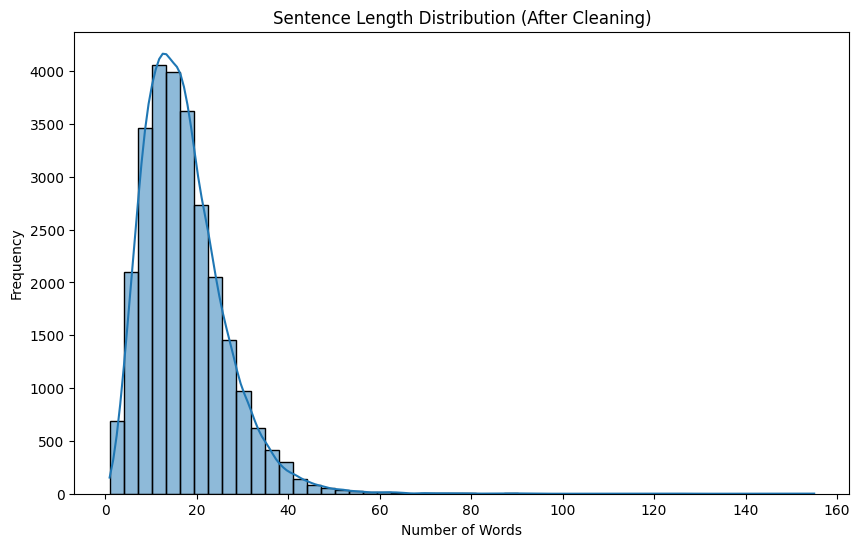

In [ ]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths_cleaned, bins=50, kde=True)
plt.title('Sentence Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

The histogram shows the sentence length distribution after cleaning, with most sentences under 40 words. The shortest sentence has 1 word, and the longest has 155. We'll now examine these extreme cases and their labels

In [ ]:
# Calculate sentence lengths as a variable
sentence_lengths = df['text'].apply(lambda x: len(x.split()))

# Find the shortest sentence
shortest_idx = sentence_lengths.idxmin()
shortest_sentence = df.loc[shortest_idx, 'text']
shortest_length = sentence_lengths[shortest_idx]
shortest_label = df.loc[shortest_idx, 'label']

# Find the longest sentence
longest_idx = sentence_lengths.idxmax()
longest_sentence = df.loc[longest_idx, 'text']
longest_length = sentence_lengths[longest_idx]
longest_label = df.loc[longest_idx, 'label']

# Display results
print(f"Shortest sentence:\n\n({shortest_length} words, label {shortest_label}):\n{shortest_sentence}\n")
print(f"Longest sentence:\n\n({longest_length} words, label {longest_label}):\n{longest_sentence}\n")

Shortest sentence:

(1 words, label 0):
abemayor

Longest sentence:

(155 words, label 1):
zoloft increased migraine and headaches frequency went from very rarely to frequently vomitting nausea initially constipated then just diarrhea disturbing twitching while trying to fall asleep not the usual twitching very dry mouth loss of libido  got better when i decreased from 150mg to 100 mg after 3 months also have occasional yawnitis as i call it which was worse in the beginning also had terrible motion sickness i have never had before from flying alot of dizziness if i forget my dose after just an hour since i decreased to 100mg a month ago irritability fall asleep at work sometimes lasting all day somewhat better after taking the medicine at noontime waking up in the middle of the night is completely resolved since taking the meds at noontime rather than before bed definitely i am not losing weight had panic attacks and that weird tingly feeling for first 2 weeks but these went away



The shortest sentence, a single word labeled as Non-ADR, reflects minimal context and may offer limited value for model training. In contrast, the longest sentence (155 words, labeled as ADR) presents a dense, unstructured list of side effects, typical of real-world adverse drug reports. These extremes highlight the need to handle both sparse and noisy inputs in NLP tasks involving patient-generated text.

### Checking Which Label Has Longer Sentences:

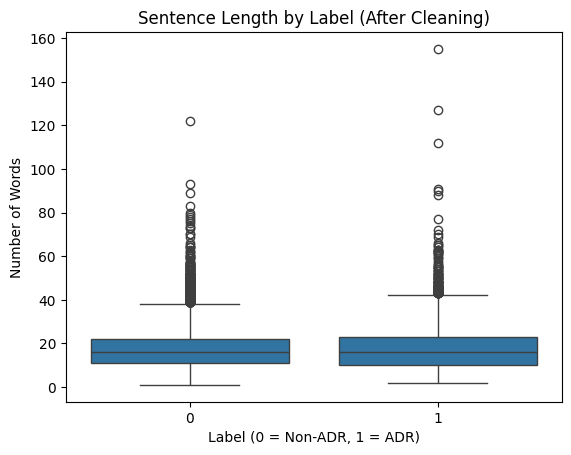

In [ ]:
# Plot sentence length distribution by label
sns.boxplot(x=df['label'], y=sentence_lengths_cleaned)
plt.title('Sentence Length by Label (After Cleaning)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

After the minimal cleaning, the distribution of sentence lengths by label remains largely the same.

In [ ]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,20436,76.06
1,1,6431,23.94


### Letters per Word:

In [ ]:
# Calculate total words and total letters
total_words = len(all_words)
total_letters = sum(len(word) for word in all_words)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total Words', 'Total Letters'],
    'Value': [total_words, total_letters]
})

# Display summary DataFrame
summary_df

,Metric,Value
0,Total Words,462108
1,Total Letters,2644876


In [ ]:
# Calculate letter statistics per word (only count shows word amount)

word_lengths = [len(word) for word in all_words]

# Convert to a pandas Series for easy summary stats
word_lengths_series = pd.Series(word_lengths, name='Amount')

# Print summary statistics
print("Letter Statistics per Word:\n")
word_lengths_series.describe().round(2)

Letter Statistics per Word:



,Amount
count,462108.00
mean,5.72
std,3.47
min,1.00
25%,3.00
50%,5.00
75%,8.00
max,42.00


In [ ]:
# Count number of words per character length
length_counts = word_lengths_series.value_counts().sort_index()

# Display as a DataFrame
length_counts_df = pd.DataFrame({
    'word_length': length_counts.index,
    'count': length_counts.values
})

length_counts_df

,word_length,count
0,1,19153
1,2,69058
2,3,69302
3,4,57241
4,5,38717
5,6,32116
6,7,37936
7,8,38585
8,9,33252
9,10,22797


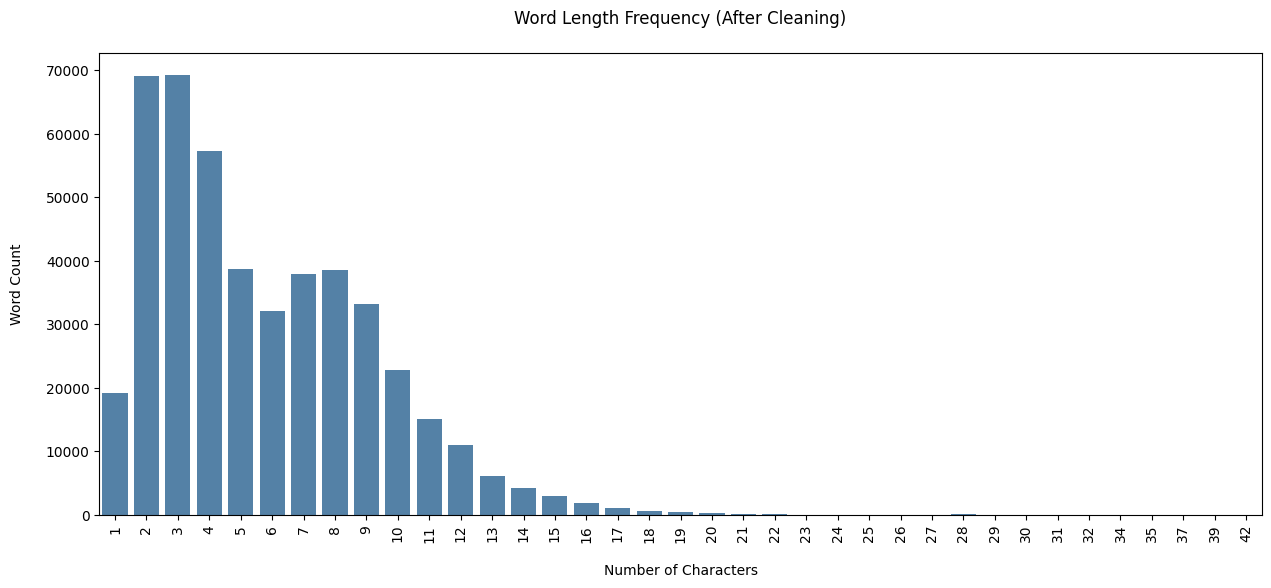

In [ ]:
# Plotting the results
plt.figure(figsize=(15, 6))
sns.barplot(x=length_counts.index, y=length_counts.values, color='steelblue')
plt.title('Word Length Frequency (After Cleaning)\n')
plt.xlabel('\nNumber of Characters')
plt.ylabel('Word Count\n')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Find all words with length >= 30
long_words = [word for word in all_words if len(word) >= 30]

# Get unique long words
unique_long_words = set(long_words)

# Display the unique long words
print("Words with 30 and more letters:\n")
for word in unique_long_words:
    print(word)

Words with 30 and more letters:

s23aminopropylaminoethylphosphorothioic
glipizidetrimethoprimsulfamethoxazole
multipleantimicrobialresistant
histologicalimmunohistochemical
antineoplasticimmunosuppressive
tricyclicantidepressantinduced
2chlorophenyl4chlorophenyl11dichloroethane
methicillinresistantstaphylococcus
1betadarabinofuranosylcytosine
prothipendylhydrochlorideinduced
n4behenoyl1betadarabinofuranosyl
trimethoprimsulfamethoxazoleinduced
chromatographynitrogenphosphorus
microbiologicalcharacteristics
tremorsdizzinessheadachesangerfits
34methylenedioxymethamphetamine
hypothalamicpituitaryadrenocortical
34methylenedioxymetamphetamine
polyendocrinopathycandidiasisectodermal
derealizationdepersonalization
reuptakeinhibitorsmetoclopramide
8hydroacydesmethylclomipramine
clinicalelectroencephalographic


We identified several unusually long words (≥30 characters), which are often complex medical terms, chemical names, or drug identifiers.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26867 entries, 0 to 26866
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     26867 non-null  object
 1   label    26867 non-null  int64 
 2   dataset  26867 non-null  object
dtypes: int64(1), object(2)
memory usage: 629.8+ KB


# Downsampling and Splitting the Data:

Since our dataset is imbalanced, with approximately 76% Non-ADR and 24% ADR examples, we will apply downsampling to the Non-ADR class to match the number of ADR examples. This ensures a balanced dataset, helping to prevent the model from being biased toward the majority class. By doing so, we aim to improve the models' ability to correctly identify ADR cases and achieve more reliable performance metrics during evaluation.

In [ ]:
# Separate majority and minority classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=0)

# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataset
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Check the new label distribution
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts

,Label,Count
0,0,6431
1,1,6431


In [ ]:
df.to_excel('/content/combined_dataset_cleaned.xlsx', index=False)

In [ ]:
# Split data into train+dev and test first (80% train+dev, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=0
)

# Split train+dev into train and dev (75% train, 25% dev → overall 60% train, 20% dev, 20% test)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp,
    test_size=0.25, stratify=y_temp, random_state=0
)

After balancing the dataset through downsampling, we split it into training (60%), development (20%), and test (20%) sets using stratified sampling to preserve label distribution. A fixed random state was used to ensure reproducibility.

# Baseline Model - Bag of Words + Naive Bayes:

In [ ]:
# Vectorize with Bag of Words (fit only on training set)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes on training set
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Predict on train set
y_train_bow_pred = nb_model.predict(X_train_vec)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, y_train_bow_pred)
train_precision = precision_score(y_train, y_train_bow_pred)
train_recall = recall_score(y_train, y_train_bow_pred)
train_f1 = f1_score(y_train, y_train_bow_pred)

# Predict on dev set
y_dev_bow_pred = nb_model.predict(X_dev_vec)

# Calculate dev metrics
dev_accuracy = accuracy_score(y_dev, y_dev_bow_pred)
dev_precision = precision_score(y_dev, y_dev_bow_pred)
dev_recall = recall_score(y_dev, y_dev_bow_pred)
dev_f1 = f1_score(y_dev, y_dev_bow_pred)

# Predict on test set
y_test_bow_pred = nb_model.predict(X_test_vec)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_bow_pred)
test_precision = precision_score(y_test, y_test_bow_pred)
test_recall = recall_score(y_test, y_test_bow_pred)
test_f1 = f1_score(y_test, y_test_bow_pred)

# Create DataFrame with results
metric_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train Score': [round(train_accuracy, 2), round(train_precision, 2), round(train_recall, 2), round(train_f1, 2)],
    'Dev Score': [round(dev_accuracy, 2), round(dev_precision, 2), round(dev_recall, 2), round(dev_f1, 2)],
    'Test Score': [round(test_accuracy, 2), round(test_precision, 2), round(test_recall, 2), round(test_f1, 2)]
})

# Display DataFrame
metric_table

,Metric,Train Score,Dev Score,Test Score
0,Accuracy,0.89,0.76,0.76
1,Precision,0.86,0.73,0.73
2,Recall,0.94,0.82,0.81
3,F1 Score,0.90,0.77,0.77


For one of our baseline models, we trained a Multinomial Naive Bayes classifier using text data vectorized with a Bag-of-Words approach. The dataset was split into training (60%), development (20%), and test (20%) sets. The model performed well on the training set (F1 = 0.90), with a moderate drop on the dev and test sets (both F1 = 0.77), suggesting some overfitting but still decent generalization. Since the goal is to detect adverse drug reactions (ADR), recall is especially important—missing an ADR could be risky. The model maintained strong recall across all splits: 0.94 (train), 0.82 (dev), and 0.81 (test), indicating it successfully captured most ADR cases. Precision was slightly lower (0.73 on dev/test), pointing to some false positives, but this tradeoff is acceptable given the emphasis on recall.


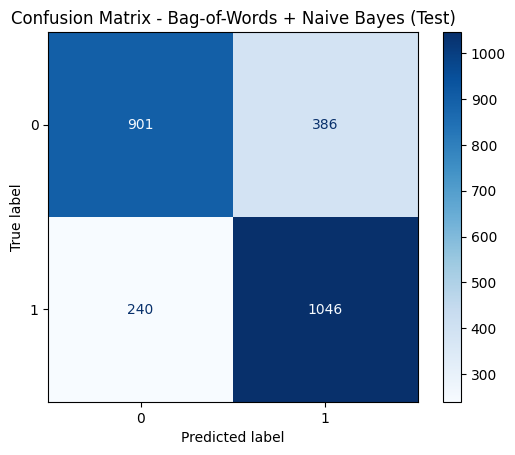

In [ ]:
cm_bow = confusion_matrix(y_test, y_test_bow_pred)
disp_bow = ConfusionMatrixDisplay(confusion_matrix=cm_bow, display_labels=[0, 1])
disp_bow.plot(cmap='Blues')
plt.title("Confusion Matrix - Bag-of-Words + Naive Bayes (Test)")
plt.show()

The confusion matrix shows the model correctly identified most ADR and Non-ADR cases, with 1,046 true positives and 901 true negatives. Despite 240 false negatives and 386 false positives, the model maintained strong recall, which is key for detecting ADRs.

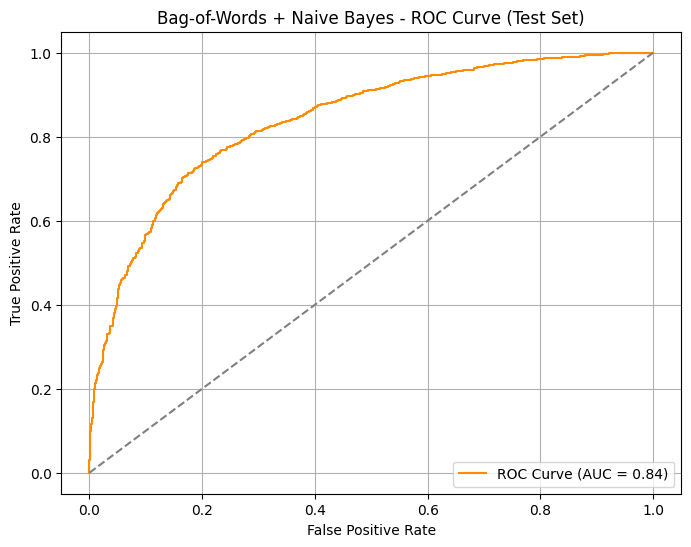

In [ ]:
# ROC Curve + AUC (Test Set)

# Get predicted probabilities for class 1 (ADR)
y_test_proba_bow = nb_model.predict_proba(X_test_vec)[:, 1]

# Compute ROC curve and AUC
fpr_bow, tpr_bow, _ = roc_curve(y_test, y_test_proba_bow)
roc_auc_bow = auc(fpr_bow, tpr_bow)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_bow, tpr_bow, label=f"ROC Curve (AUC = {roc_auc_bow:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bag-of-Words + Naive Bayes - ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Embedding Models:

We will train classifiers using Logistic Regression on embeddings from BioBERT, SBERT, and InstructorXL, and compare their performance to each other as well as to large language models (LLMs) in a separate evaluation.

## SBERT:

In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dimensional embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Encode texts to embeddings
X_train_embed = sbert_model.encode(X_train.tolist(), convert_to_tensor=False)
X_dev_embed = sbert_model.encode(X_dev.tolist(), convert_to_tensor=False)
X_test_embed = sbert_model.encode(X_test.tolist(), convert_to_tensor=False)

In [ ]:
# Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embed, y_train)

LogisticRegression(max_iter=1000)

We used the all-MiniLM-L6-v2 variant of SBERT to generate 384-dimensional sentence embeddings for all text inputs. These embeddings capture contextual semantics more effectively than traditional word-count methods. The encoded vectors were then used to train a Logistic Regression classifier for ADR detection.

In [ ]:
# Predictions
y_train_sbert_pred = clf.predict(X_train_embed)
y_dev_sbert_pred = clf.predict(X_dev_embed)
y_test_sbert_pred = clf.predict(X_test_embed)

# Metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 2),
        "Precision": round(precision_score(y_true, y_pred), 2),
        "Recall": round(recall_score(y_true, y_pred), 2),
        "F1 Score": round(f1_score(y_true, y_pred), 2),
    }

# Create a DataFrame with all results
sbert_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": list(compute_metrics(y_train, y_train_sbert_pred).values()),
    "Dev": list(compute_metrics(y_dev, y_dev_sbert_pred).values()),
    "Test": list(compute_metrics(y_test, y_test_sbert_pred).values()),
})

# Display metrics
print("SBERT Classification Metrics:")
display(sbert_metrics_df)

SBERT Classification Metrics:


,Metric,Train,Dev,Test
0,Accuracy,0.81,0.78,0.78
1,Precision,0.80,0.77,0.77
2,Recall,0.82,0.79,0.80
3,F1 Score,0.81,0.78,0.78


The SBERT-based model showed consistent performance across all splits, with F1 scores of 0.81 (train), 0.78 (dev), and 0.78 (test). Compared to the Bag-of-Words baseline, this model had slightly lower recall but improved precision and better generalization, suggesting it captures more meaningful patterns while reducing false positives.

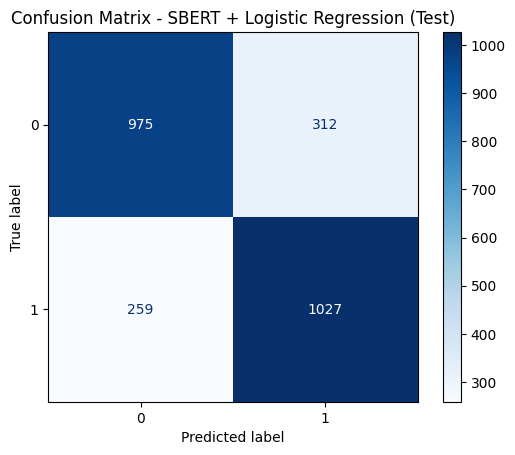

In [ ]:
# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_test_sbert_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SBERT + Logistic Regression (Test)")
plt.show()

The confusion matrix shows that the SBERT + Logistic Regression model correctly classified 1,027 ADR cases and 975 Non-ADR cases. It misclassified 259 ADRs (false negatives) and 312 Non-ADRs (false positives). While recall remains strong, the false negatives highlight areas for further improvement in ADR detection.

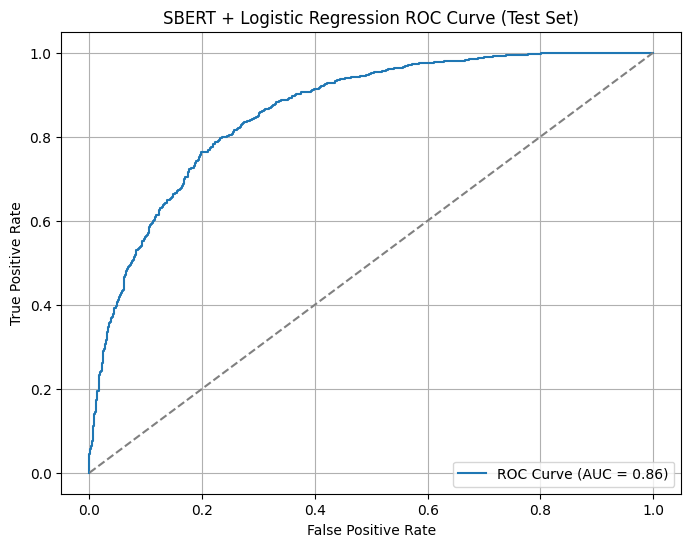

In [ ]:
# ROC Curve and AUC (Test Set)
# Use predicted probabilities for ROC
y_test_proba = clf.predict_proba(X_test_embed)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SBERT + Logistic Regression ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## BioBERT:

In [ ]:
!pip install transformers torch scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.7 MB/s eta 0:00:00


In [ ]:
pip install transformers tqdm

In [ ]:
from transformers import AutoTokenizer, AutoModel
# Load BioBERT model
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# Define a sentence embedding function
def get_biobert_embeddings_batched(texts, tokenizer, model, batch_size=16, device="cuda" or "cpu"):
    model.to(device)
    model.eval()
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Generating BioBERT Embeddings"):
            batch = texts[i:i + batch_size]
            encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)
            output = model(**encoded_input)
            cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_embeddings.cpu())

    return torch.cat(embeddings).numpy()

In [ ]:
# Generate Embeddings
X_train_embed_bio = get_biobert_embeddings_batched(X_train.tolist(), biobert_tokenizer, biobert_model)
X_dev_embed_bio = get_biobert_embeddings_batched(X_dev.tolist(), biobert_tokenizer, biobert_model)
X_test_embed_bio = get_biobert_embeddings_batched(X_test.tolist(), biobert_tokenizer, biobert_model)

Generating BioBERT Embeddings:   0%|          | 0/483 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Generating BioBERT Embeddings:   0%|          | 0/161 [00:00<?, ?it/s]

Generating BioBERT Embeddings:   0%|          | 0/161 [00:00<?, ?it/s]

In [ ]:
# Train Logistic Regression using BioBERT Embeddings

# Initialize logistic regression model (higher max_iter ensures convergence)
bio_model = LogisticRegression(max_iter=1000)

# Train on BioBERT-embedded training set
bio_model.fit(X_train_embed_bio, y_train)


# Evaluate on Training Set
y_train_pred_bio = bio_model.predict(X_train_embed_bio)
train_accuracy = accuracy_score(y_train, y_train_pred_bio)
train_precision = precision_score(y_train, y_train_pred_bio)
train_recall = recall_score(y_train, y_train_pred_bio)
train_f1 = f1_score(y_train, y_train_pred_bio)


# Evaluate on Development (Dev) Set
y_dev_pred_bio = bio_model.predict(X_dev_embed_bio)
dev_accuracy = accuracy_score(y_dev, y_dev_pred_bio)
dev_precision = precision_score(y_dev, y_dev_pred_bio)
dev_recall = recall_score(y_dev, y_dev_pred_bio)
dev_f1 = f1_score(y_dev, y_dev_pred_bio)

# Evaluate on Test Set
y_test_pred_bio = bio_model.predict(X_test_embed_bio)
test_accuracy = accuracy_score(y_test, y_test_pred_bio)
test_precision = precision_score(y_test, y_test_pred_bio)
test_recall = recall_score(y_test, y_test_pred_bio)
test_f1 = f1_score(y_test, y_test_pred_bio)

# Compile all metrics into a single DataFrame for display
bio_metric_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train Score': [round(train_accuracy, 2), round(train_precision, 2), round(train_recall, 2), round(train_f1, 2)],
    'Dev Score': [round(dev_accuracy, 2), round(dev_precision, 2), round(dev_recall, 2), round(dev_f1, 2)],
    'Test Score': [round(test_accuracy, 2), round(test_precision, 2), round(test_recall, 2), round(test_f1, 2)]
})

# Display the final metric table
print("BioBERT Classification Metrics:")
bio_metric_table

BioBERT Classification Metrics:


,Metric,Train Score,Dev Score,Test Score
0,Accuracy,0.87,0.81,0.82
1,Precision,0.86,0.80,0.82
2,Recall,0.88,0.82,0.82
3,F1 Score,0.87,0.81,0.82


We used BioBERT, a domain-specific language model pre-trained on biomedical literature, to generate sentence embeddings for our classification task. Each sentence was encoded using the [CLS] token representation, and the resulting embeddings were used to train a Logistic Regression classifier. The model performed consistently across all splits, with F1 scores of 0.87 on the training set, 0.81 on the development set, and 0.82 on the test set. Compared to SBERT, BioBERT showed slightly better generalization and overall performance, likely due to its specialization in biomedical text, which aligns well with the ADR detection task.

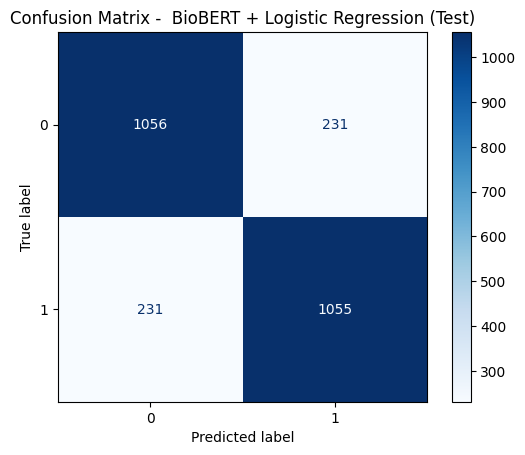

In [ ]:
# Confusion Matrix (Test Set)
cm_bio = confusion_matrix(y_test, y_test_pred_bio)
disp_bio = ConfusionMatrixDisplay(confusion_matrix=cm_bio, display_labels=[0, 1])
disp_bio.plot(cmap='Blues')
plt.title("Confusion Matrix -  BioBERT + Logistic Regression (Test)")
plt.show()

The BioBERT + Logistic Regression model correctly classified 1,055 ADR cases and 1,056 Non-ADR cases on the test set. It misclassified 231 instances from each class. This balanced performance reflects the model’s strong ability to distinguish between ADR and Non-ADR texts, with fewer false negatives compared to the SBERT model.

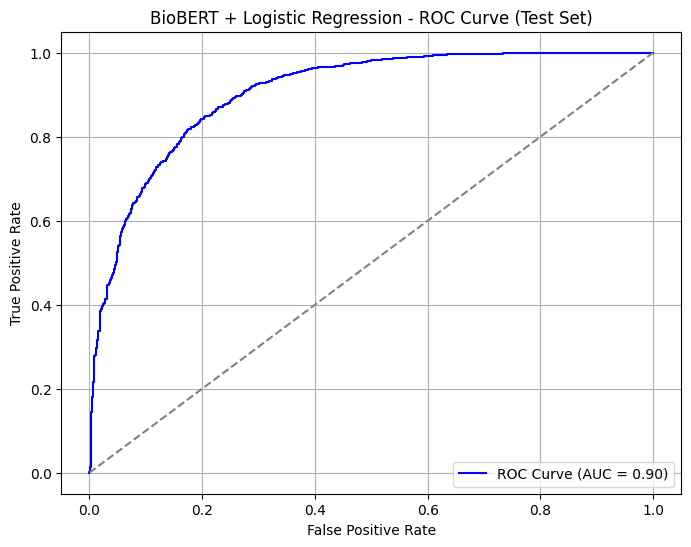

In [ ]:
# ROC Curve + AUC (Test Set)
y_test_proba_bio = bio_model.predict_proba(X_test_embed_bio)[:, 1]
fpr_bio, tpr_bio, _ = roc_curve(y_test, y_test_proba_bio)
roc_auc_bio = auc(fpr_bio, tpr_bio)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bio, tpr_bio, label=f"ROC Curve (AUC = {roc_auc_bio:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BioBERT + Logistic Regression - ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## InstructorXL:

In [ ]:
!pip install sentence-transformers scikit-learn matplotlib --quiet

In [ ]:
# Load InstructorXL
model = SentenceTransformer("hkunlp/instructor-xl")
instruction = "Represent the sentence for binary classification: adverse drug reaction (ADR) detection. 1 for ADR and 0 for non ADR"

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Embed with instruction
X_train_embed_inst = model.encode([[instruction, s] for s in X_train.tolist()])
X_dev_embed_inst = model.encode([[instruction, s] for s in X_dev.tolist()])
X_test_embed_inst = model.encode([[instruction, s] for s in X_test.tolist()])

In [ ]:
# Train Logistic Regression classifier on InstructorXL embeddings
inst_clf = LogisticRegression(max_iter=1000)
inst_clf.fit(X_train_embed_inst, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Predict on train/dev/test sets
y_train_pred_inst = inst_clf.predict(X_train_embed_inst)
y_dev_pred_inst = inst_clf.predict(X_dev_embed_inst)
y_test_pred_inst = inst_clf.predict(X_test_embed_inst)

In [ ]:
# Metrics function
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 2),
        "Precision": round(precision_score(y_true, y_pred), 2),
        "Recall": round(recall_score(y_true, y_pred), 2),
        "F1 Score": round(f1_score(y_true, y_pred), 2),
    }

# Metrics table
inst_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Train": list(compute_metrics(y_train, y_train_pred_inst).values()),
    "Dev": list(compute_metrics(y_dev, y_dev_pred_inst).values()),
    "Test": list(compute_metrics(y_test, y_test_pred_inst).values()),
})

# Display metrics
print("Instructor-XL Classification Metrics:")
inst_metrics_df

Instructor-XL Classification Metrics:


,Metric,Train,Dev,Test
0,Accuracy,0.83,0.82,0.81
1,Precision,0.83,0.81,0.81
2,Recall,0.84,0.84,0.81
3,F1 Score,0.83,0.82,0.81


We used InstructorXL, a large instruction-tuned embedding model, to generate contextual sentence embeddings guided by a specific task prompt: "Represent the sentence for binary classification: adverse drug reaction (ADR) detection. 1 for ADR and 0 for non ADR".

These embeddings were used to train a Logistic Regression classifier. The model achieved stable results across splits, with an F1 score of 0.83 on the training set, 0.82 on the development set, and 0.81 on the test set.

While slightly below BioBERT’s performance, InstructorXL maintained a strong balance between precision and recall, showing its potential as a general-purpose model even without domain-specific training.



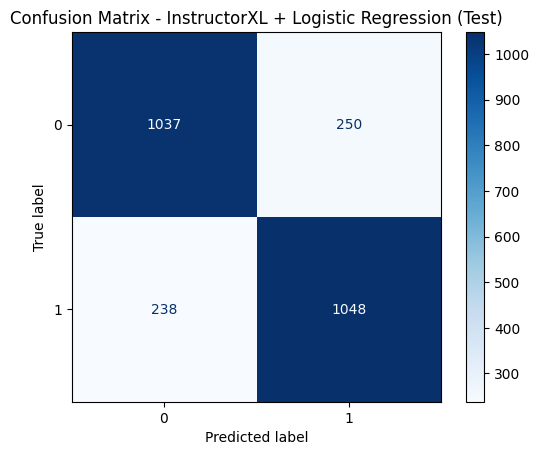

In [ ]:
# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_test_pred_inst)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - InstructorXL + Logistic Regression (Test)")
plt.show()

The InstructorXL + Logistic Regression model correctly identified 1,048 ADR cases and 1,037 Non-ADR cases. It misclassified 238 ADRs and 250 Non-ADRs. These results reflect a well-balanced performance with slightly fewer false negatives than SBERT, though still slightly behind BioBERT in overall accuracy.

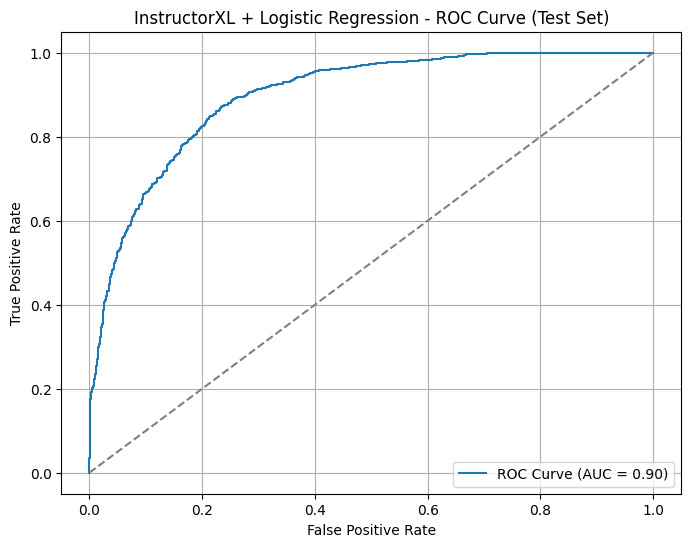

In [ ]:
# ROC Curve + AUC (Test Set)
y_test_proba_inst = inst_clf.predict_proba(X_test_embed_inst)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_proba_inst)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("InstructorXL + Logistic Regression - ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

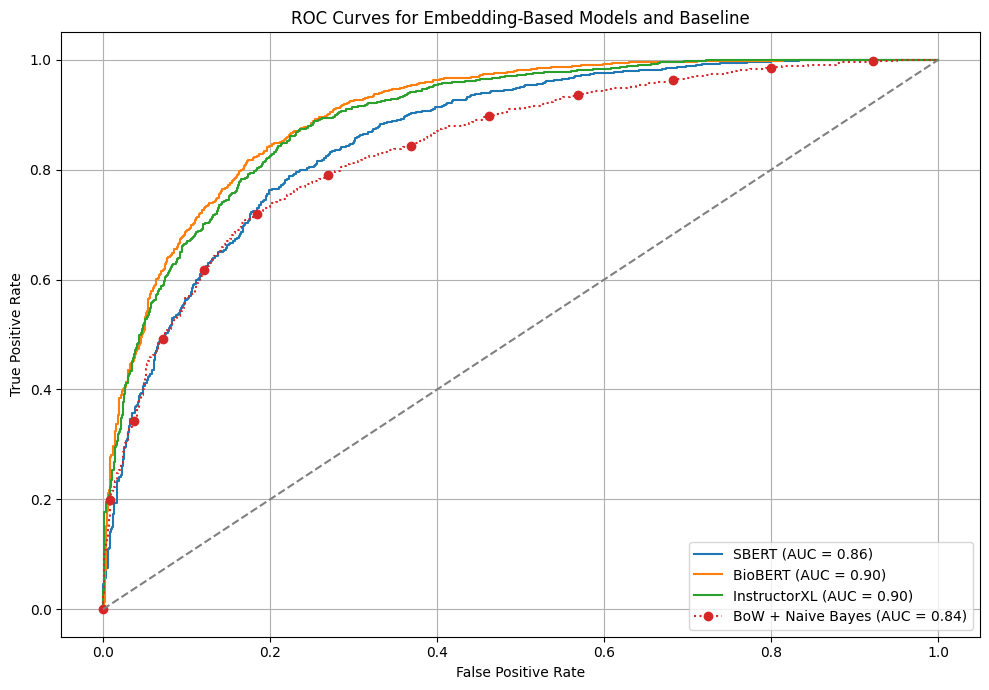

In [ ]:
# Compute ROC and AUC for all four models
sbert_proba = clf.predict_proba(X_test_embed)[:, 1]
bio_proba = bio_model.predict_proba(X_test_embed_bio)[:, 1]
inst_proba = inst_clf.predict_proba(X_test_embed_inst)[:, 1]
bow_proba = nb_model.predict_proba(X_test_vec)[:, 1]

fpr_sbert, tpr_sbert, _ = roc_curve(y_test, sbert_proba)
fpr_bio, tpr_bio, _ = roc_curve(y_test, bio_proba)
fpr_inst, tpr_inst, _ = roc_curve(y_test, inst_proba)
fpr_bow, tpr_bow, _ = roc_curve(y_test, bow_proba)

auc_sbert = auc(fpr_sbert, tpr_sbert)
auc_bio = auc(fpr_bio, tpr_bio)
auc_inst = auc(fpr_inst, tpr_inst)
auc_bow = auc(fpr_bow, tpr_bow)

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_sbert, tpr_sbert, label=f"SBERT (AUC = {auc_sbert:.2f})")
plt.plot(fpr_bio, tpr_bio, label=f"BioBERT (AUC = {auc_bio:.2f})")
plt.plot(fpr_inst, tpr_inst, label=f"InstructorXL (AUC = {auc_inst:.2f})")

# Add Bag-of-Words baseline as dotted line
plt.plot(fpr_bow, tpr_bow, linestyle=':', marker='o', markevery=0.1, label=f"BoW + Naive Bayes (AUC = {auc_bow:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Embedding-Based Models and Baseline")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve above compares the performance of four models for classifying adverse drug reaction (ADR) sentences.

BioBERT and InstructorXL achieved the highest performance with an AUC of 0.90, indicating strong discriminative ability between ADR and non-ADR texts. SBERT followed with an AUC of 0.86, while the Bag-of-Words (BoW) + Naive Bayes baseline achieved a respectable AUC of 0.84, despite its simplicity.

Interestingly, the baseline model, visualized using a dotted line with red markers, performs competitively but shows slightly lower sensitivity in certain regions of the curve. In contrast, the transformer-based models benefit from contextual embeddings, resulting in higher true positive rates across most thresholds.

We can see that classical models like the baseline still provide a solid benchmark in low-resource or fast-deployment scenarios.

# LLM Models:

In [ ]:
# Connecting to Azure

# Shared Azure config
api_version = "2024-12-01-preview"
endpoint = "" # Add the endpoint here
api_key = "" # Add your key here

# One client for all deployments
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=api_key,
)

In [ ]:
# Connecting to Hugging Face

# Login with Hugging Face token
from huggingface_hub import login
login(token="") # Add your token here

# Load the Llama-3.2-3B-Instruct model from Hugging Face
pipe = pipeline(
    "text-generation",
    model="meta-llama/Llama-3.2-3B-Instruct",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
!pip install azure-ai-inference --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 18.0 MB/s eta 0:00:00


In [ ]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential

In [ ]:
# Run classification on the test set
df_test = pd.DataFrame({'text': X_test, 'label': y_test})

To evaluate large language models (LLMs) on our ADR classification task, we set up connections to both Azure OpenAI and Hugging Face. From Azure, we accessed deployed models via the azure-ai-inference package, and from Hugging Face, we loaded the LLaMA-3.2–3B-Instruct model using instruction-based prompting. We prepared the test set (text, label) for inference and plan to pass each sample through the respective LLMs to generate binary predictions, enabling direct comparison between traditional embedding-based models and LLMs.

## Phi-4-mini-instruct:

### Phi-4-mini-instruct Zero-shot:

In [ ]:
def zero_shot_phi4_classify(text):
    prompt = f"""
You are a medical NLP classifier.

Classify the following sentence as describing an Adverse Drug Reaction (ADR) or not.

Sentence:
"{text}"

Respond with only a single digit:
- Respond 1 if it describes an ADR.
- Respond 0 if it does NOT describe an ADR.
""".strip()

    try:
        response = client.chat.completions.create(
            model="Phi-4-mini-instruct",
            messages=[
                {"role": "system", "content": "You classify medical sentences as ADR (1) or non-ADR (0)."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=5,
            temperature=0.0,
        )
        output = response.choices[0].message.content.strip()
        return int(output) if output in ["0", "1"] else None
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['phi4_zeroshot_pred'] = [
    zero_shot_phi4_classify(text) for text in tqdm(df_test['text'], desc="Phi-4-mini Zero-Shot Classification")
]

# Remove rows where classification failed
df_test_phi4 = df_test.dropna(subset=['phi4_zeroshot_pred'])

# Show classification stats
total = len(df_test)
valid = len(df_test_phi4)
invalid = total - valid
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({round(invalid / total * 100, 2)}%)")

# Evaluate the predictions
y_true_phi4_zero = df_test_phi4['label']
y_pred_phi4_zero = df_test_phi4['phi4_zeroshot_pred']

phi4_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Phi-4-mini Zero-Shot Score": [
        round(accuracy_score(y_true_phi4_zero, y_pred_phi4_zero), 2),
        round(precision_score(y_true_phi4_zero, y_pred_phi4_zero), 2),
        round(recall_score(y_true_phi4_zero, y_pred_phi4_zero), 2),
        round(f1_score(y_true_phi4_zero, y_pred_phi4_zero), 2)
    ]
})

phi4_metrics_df

Phi-4-mini Zero-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': True, 'severity': 'medium'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
Total: 2573 | Valid: 2485 | Invalid: 88 (3.42%)


,Metric,Phi-4-mini Zero-Shot Score
0,Accuracy,0.77
1,Precision,0.73
2,Recall,0.87
3,F1 Score,0.79


We evaluated Phi-4-mini-instruct in a zero-shot setting via Azure OpenAI, using a simple prompt to classify sentences as describing an ADR (1) or not (0). Out of 2,573 test samples, 3.4% were filtered by Microsoft’s content moderation, leaving 2,485 valid predictions. The model achieved an F1 score of 0.79, with strong recall (0.87) and moderate precision (0.73). These results indicate that even without fine-tuning or examples, the model performs well at identifying ADR cases, though some safety filters limit its applicability on certain inputs.

In [ ]:
# Show filtered out rows (if you kept them before dropna)
df_invalid_phi4_zeroshot = df_test[df_test['phi4_zeroshot_pred'].isna()]
df_invalid_phi4_zeroshot['text'].head(10)

,text
3944,cymbalta i took prozac instead of the cymbalta...
1979,lexapro lexapro has given me my life back
12246,the cost of the demanding lifestyle of militar...
12358,cranial mri showed large asymmetric t2 and fla...
700,mr of the brain was performed in eight patient...
10360,conclusion the final interpretation of the les...
2233,the radiographic and ct scan show the typical ...
2741,pharmacokinetic modeling suggested that the pa...
8752,zoloft i feel normal around people for the fir...
6472,this case along with extensive reports in the ...


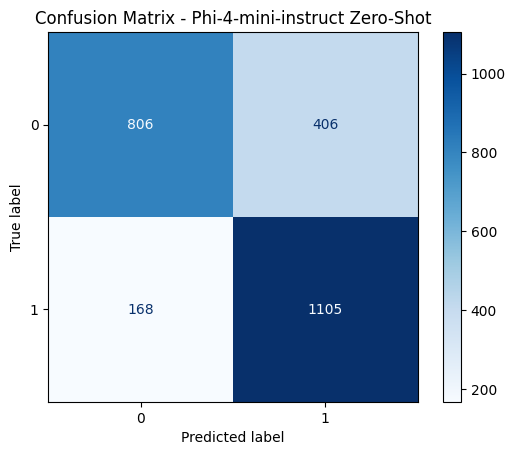

In [ ]:
# Confusion matrix for Phi-4-mini-instruct Zero-Shot
cm_phi4_zeroshot = confusion_matrix(y_true_phi4_zero, y_pred_phi4_zero)

# Display the matrix
disp_phi4_zeroshot = ConfusionMatrixDisplay(confusion_matrix=cm_phi4_zeroshot, display_labels=[0, 1])
disp_phi4_zeroshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Phi-4-mini-instruct Zero-Shot")
plt.show()

The confusion matrix for Phi-4-mini-instruct (zero-shot) shows 1,105 true positives and 168 false negatives for ADR cases, indicating strong recall. However, the 406 false positives lowered precision. This suggests that while the model effectively detects most ADRs, it tends to overpredict, prioritizing recall at the expense of precision.

### Phi-4-mini-instruct Few-shot:

In [ ]:
def few_shot_phi4_classify(text):
    few_shot_examples = [
        {"text": "lexapro and i still have occasional heart flutters a clenched stomach and the anxiety that goes with that", "label": 1},
        {"text": "phantom limb pain as a manifestation of paclitaxel neurotoxicity", "label": 1},
        {"text": "cymbalta i highly recomment it to anyone", "label": 0},
        {"text": "all three patients had been taking an atypical antipsychotic", "label": 0},
    ]

    # Compact prompt format
    example_prompt = " ".join([f'"{ex["text"]}" → {ex["label"]};' for ex in few_shot_examples])
    full_prompt = f"""
You classify medical sentences as Adverse Drug Reactions (ADR = 1) or not (ADR = 0).

Examples: {example_prompt}

Now: "{text}" →
""".strip()

    try:
        response = client.chat.completions.create(
            model="Phi-4-mini-instruct",
            messages=[
                {"role": "system", "content": "You classify medical sentences as ADR (1) or non-ADR (0)."},
                {"role": "user", "content": full_prompt}
            ],
            max_tokens=5,
            temperature=0.0,
            top_p=1.0
        )
        output = response.choices[0].message.content.strip()

        # Flexibly match digit in output
        match = re.search(r"\b([01])\b", output)
        return int(match.group(1)) if match else None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['phi4_fewshot_pred'] = [
    few_shot_phi4_classify(text) for text in tqdm(df_test['text'], desc="Phi-4 Few-Shot Classification")
]

# Filter out failed predictions
df_test_phi4_few = df_test.dropna(subset=['phi4_fewshot_pred'])

# Show classification stats
total = len(df_test)
valid = len(df_test_phi4_few)
invalid = total - valid
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({round(invalid / total * 100, 2)}%)")

# Evaluation
y_true_phi4_few = df_test_phi4_few['label']
y_pred_phi4_few = df_test_phi4_few['phi4_fewshot_pred']

# Create metric table
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Phi-4 Few-Shot Score": [
        round(accuracy_score(y_true_phi4_few, y_pred_phi4_few), 2),
        round(precision_score(y_true_phi4_few, y_pred_phi4_few), 2),
        round(recall_score(y_true_phi4_few, y_pred_phi4_few), 2),
        round(f1_score(y_true_phi4_few, y_pred_phi4_few), 2)
    ]
}

phi4_fewshot_df = pd.DataFrame(metrics)
phi4_fewshot_df

Phi-4 Few-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Microsoft's content management policy. Please modify your prompt and retry.", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': True, 'severity': 'medium'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
Total: 2573 | Valid: 2565 | Invalid: 8 (0.31%)


,Metric,Phi-4 Few-Shot Score
0,Accuracy,0.73
1,Precision,0.75
2,Recall,0.69
3,F1 Score,0.72


We also evaluated the Phi-4-mini-instruct model in a few-shot setting by providing four labeled examples within the prompt to guide the classification. The model was asked to determine whether each test sentence described an ADR (1) or not (0). Compared to the zero-shot version, the few-shot setup resulted in slightly worse recall (0.69 vs. 0.87) and F1 score (0.72 vs. 0.79), although it had a marginally higher precision (0.75). These results suggest that few-shot prompting did not improve overall performance in this context and that the model may have become more conservative in identifying ADRs, missing more true positives.

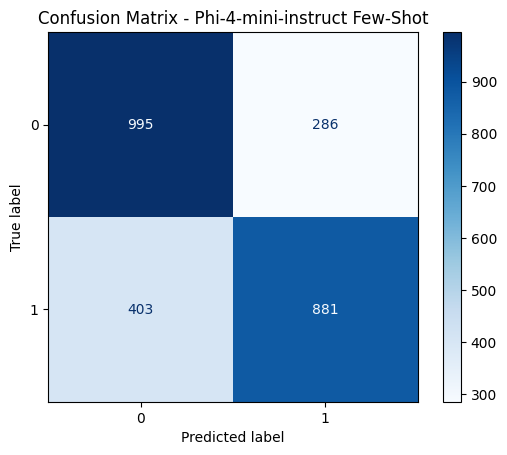

In [ ]:
# Confusion matrix for Phi-4-mini-instruct Few-Shot
cm_phi4_fewshot = confusion_matrix(y_true_phi4_few, y_pred_phi4_few)

# Display the matrix
disp_phi4_fewshot = ConfusionMatrixDisplay(confusion_matrix=cm_phi4_fewshot, display_labels=[0, 1])
disp_phi4_fewshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Phi-4-mini-instruct Few-Shot")
plt.show()

The Phi-4-mini-instruct few-shot model had 881 true positives and 403 false negatives, showing lower recall than the zero-shot version. It reduced false positives to 286, which improved precision. Overall, it was more conservative—favoring precision over recall—with an F1 score of 0.72. Only 0.31% of outputs were invalid.

## Llama-3.2-3B-Instruct:

In [ ]:
!pip install transformers --upgrade

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

### Llama-3.2-3B-Instruct Zero-shot:

In [ ]:
def llama_zero_shot_classify(text):
    prompt = (
        "You are a medical NLP classifier. Only classify a sentence as an Adverse Drug Reaction (ADR = 1) if it clearly describes a harmful effect of a medication.\n\n"
        "Otherwise, classify it as non-ADR (0).\n\n"
        "Answer using only a single digit: 1 or 0.\n\n"
        f"\"{text}\" →"
    )
    try:
        response = pipe(
            prompt,
            max_new_tokens=5,
            temperature=0.1,
            top_p=1.0,
            return_full_text=False
        )[0]["generated_text"]

        response_clean = response.strip()

        if response_clean.startswith("1"):
            return 1
        elif response_clean.startswith("0"):
            return 0

        # Fallback to regex match
        match = re.search(r"(?:\b|[^0-9])([01])(?:\b|[^0-9])", response_clean)
        return int(match.group(1)) if match else None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['llama_pred'] = [
    llama_zero_shot_classify(text) for text in tqdm(df_test['text'], desc="LLaMA Zero-Shot (Improved)")
]

# Filter out invalid results
df_llama_valid = df_test.dropna(subset=['llama_pred'])

# Stats
total = len(df_test)
valid = len(df_llama_valid)
invalid = total - valid
invalid_pct = round(invalid / total * 100, 2)
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({invalid_pct}%)")

# Evaluation
y_true_llama_zero = df_llama_valid['label']
y_pred_llama_zero = df_llama_valid['llama_pred']

llama_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "LLaMA Zero-Shot Score": [
        round(accuracy_score(y_true_llama_zero, y_pred_llama_zero), 2),
        round(precision_score(y_true_llama_zero, y_pred_llama_zero), 2),
        round(recall_score(y_true_llama_zero, y_pred_llama_zero), 2),
        round(f1_score(y_true_llama_zero, y_pred_llama_zero), 2)
    ]
})

llama_metrics

LLaMA Zero-Shot (Improved):   0%|          | 0/2573 [00:00<?, ?it/s]

Total: 2573 | Valid: 2573 | Invalid: 0 (0.0%)


,Metric,LLaMA Zero-Shot Score
0,Accuracy,0.71
1,Precision,0.73
2,Recall,0.66
3,F1 Score,0.70


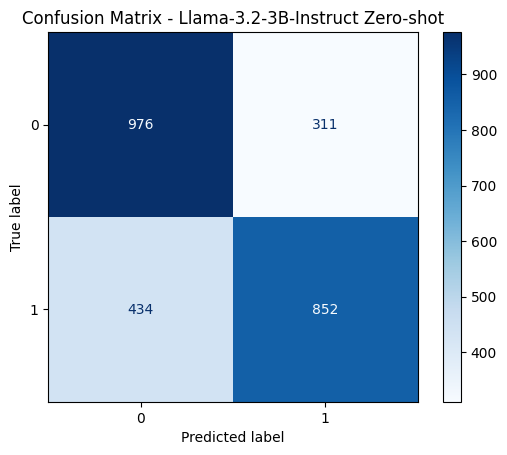

In [ ]:
# Confusion matrix for Llama-3.2-3B-Instruct Zero-shot
cm_llama_zeroshot = confusion_matrix(y_true_llama_zero, y_pred_llama_zero)

# Display the matrix
disp_llama_zeroshot = ConfusionMatrixDisplay(confusion_matrix=cm_llama_zeroshot, display_labels=[0, 1])
disp_llama_zeroshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Llama-3.2-3B-Instruct Zero-shot")
plt.show()

We evaluated the LLaMA-3.2-3B-Instruct model in a zero-shot setting using a basic instruction prompt. The model completed all predictions without invalid outputs. However, its performance was relatively lower than the previous models, with an F1 score of 0.70 and recall of 0.66.

The confusion matrix revealed a high number of false negatives, indicating that the model often failed to identify ADR cases.

### Llama-3.2-3B-Instruct Few-shot:

In [ ]:
few_shot_examples = [
    {"text": "morphea after bromocriptine therapy", "label": 1},
    {"text": "gastrooesophageal reflux associated with nifedipine", "label": 1},
    {"text": "lexapro  extreme fatigue night sweats always too warm slight jaw clenching vivid dreams", "label": 1},
    {"text": "paclitaxel was an effective therapy in this setting", "label": 0},
    {"text": "she was treated with fluid resuscitation wound dressing and antibiotics", "label": 0},
    {"text": "the optic nerve appeared healthy with no visible swelling in each eye", "label": 0},
]

In [ ]:
def llama_few_shot_classify(text):
    # Format examples into prompt
    examples_block = "\n\n".join([
        f'Sentence: "{ex["text"]}"\nLabel: {ex["label"]}' for ex in few_shot_examples
    ])

    prompt = f"""
You are a medical sentence classifier.

Classify whether the following sentence describes an Adverse Drug Reaction (ADR = 1) or not (ADR = 0).

Only respond with a single digit: 0 or 1.

Examples:
{examples_block}

Now classify this sentence:

Sentence: "{text}"
Label:""".strip()

    try:
        response = pipe(
            prompt,
            max_new_tokens=5,
            temperature=0.1,
            top_p=1.0,  # reduce randomness for better reliability
            return_full_text=False
        )[0]["generated_text"]

        response_clean = response.strip()
        match = re.search(r"\b([01])\b", response_clean)
        return int(match.group(1)) if match else None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# Run classification
df_test = pd.DataFrame({'text': X_test, 'label': y_test})
df_test['llama_fewshot_pred'] = [llama_few_shot_classify(text) for text in tqdm(df_test['text'], desc="LLaMA Few-Shot")]

# Keep only valid predictions
df_llama_few = df_test.dropna(subset=['llama_fewshot_pred'])

# Report stats
total = len(df_test)
valid = len(df_llama_few)
invalid = total - valid
invalid_pct = round(invalid / total * 100, 2)
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({invalid_pct}%)")

# Evaluate
y_true_llama_few = df_llama_few['label']
y_pred_llama_few = df_llama_few['llama_fewshot_pred']

llama_few_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "LLaMA Few-Shot Score": [
        round(accuracy_score(y_true_llama_few, y_pred_llama_few), 2),
        round(precision_score(y_true_llama_few, y_pred_llama_few), 2),
        round(recall_score(y_true_llama_few, y_pred_llama_few), 2),
        round(f1_score(y_true_llama_few, y_pred_llama_few), 2)
    ]
})

llama_few_metrics

LLaMA Few-Shot:   0%|          | 0/2573 [00:00<?, ?it/s]

Total: 2573 | Valid: 2221 | Invalid: 352 (13.68%)


,Metric,LLaMA Few-Shot Score
0,Accuracy,0.60
1,Precision,0.74
2,Recall,0.36
3,F1 Score,0.49


LLaMA Few-Shot returned invalid predictions for ~14% of test samples (364/2573), which may have impacted overall scores.

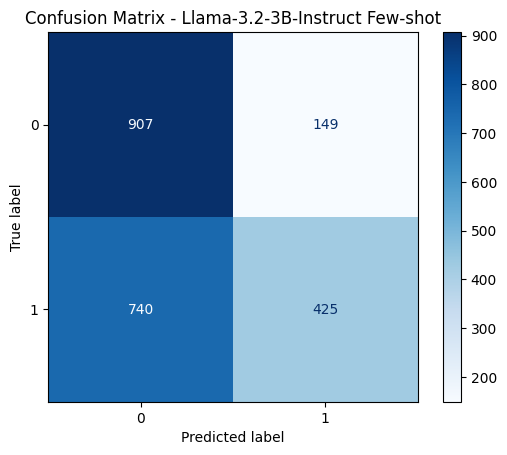

In [ ]:
# Confusion matrix for Llama-3.2-3B-Instruct Few-shot
cm_llama_fewshot = confusion_matrix(y_true_llama_few, y_pred_llama_few)

# Display the matrix
disp_llama_fewshot = ConfusionMatrixDisplay(confusion_matrix=cm_llama_fewshot, display_labels=[0, 1])
disp_llama_fewshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Llama-3.2-3B-Instruct Few-shot")
plt.show()

To evaluate a few-shot classification for this model, we provided six labeled examples (3 ADR, 3 non-ADR) in the prompt and asked the model to classify new sentences using a simple 0/1 response format. Out of 2,573 test samples, 2,221 (86.3%) were valid responses.

Performance was relatively low, with 0.60 accuracy and 0.49 F1 score. Precision was decent (0.74), but recall was poor (0.36), indicating the model often failed to detect ADRs. The confusion matrix confirms this, with many false negatives (740).

Overall, the model struggled to generalize from few examples.

## GPT-4o-mini:

### Baseline Model - GPT-4o-mini Zero-shot:

In [ ]:
!pip install openai --quiet

In [ ]:
# Zero-Shot Classifier
def zero_shot_gpt_classify(text):
    prompt = f"""
You are a medical NLP classifier.

Classify the following sentence as describing an Adverse Drug Reaction (ADR) or not.

Sentence:
"{text}"

Respond with only a single digit:
- Respond 1 if it describes an ADR.
- Respond 0 if it does NOT describe an ADR.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You classify medical sentences as ADR (1) or non-ADR (0)."},
                {"role": "user", "content": prompt.strip()}
            ],
            max_tokens=5,
            temperature=0.0,
        )
        output = response.choices[0].message.content.strip()
        return int(output) if output in ['0', '1'] else None
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['gpt_pred'] = [
    zero_shot_gpt_classify(text) for text in tqdm(df_test['text'], desc="GPT-4o-mini Zero-Shot Classification")
]

# Drop rows where the model failed (returned None)
df_test_clean = df_test.dropna(subset=['gpt_pred'])

# Evaluation
y_true_gpt4o_mini_zero = df_test_clean['label']
y_pred_gpt4o_mini_zero = df_test_clean['gpt_pred']

# Creating a metrics DataFrame
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "GPT-4o-mini Score": [
        round(accuracy_score(y_true_gpt4o_mini_zero, y_pred_gpt4o_mini_zero), 2),
        round(precision_score(y_true_gpt4o_mini_zero, y_pred_gpt4o_mini_zero), 2),
        round(recall_score(y_true_gpt4o_mini_zero, y_pred_gpt4o_mini_zero), 2),
        round(f1_score(y_true_gpt4o_mini_zero, y_pred_gpt4o_mini_zero), 2)
    ]
}

metrics_df = pd.DataFrame(metrics)

# Results
metrics_df

GPT-4o-mini Zero-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': True, 'severity': 'medium'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}


,Metric,GPT-4o-mini Score
0,Accuracy,0.84
1,Precision,0.81
2,Recall,0.89
3,F1 Score,0.85


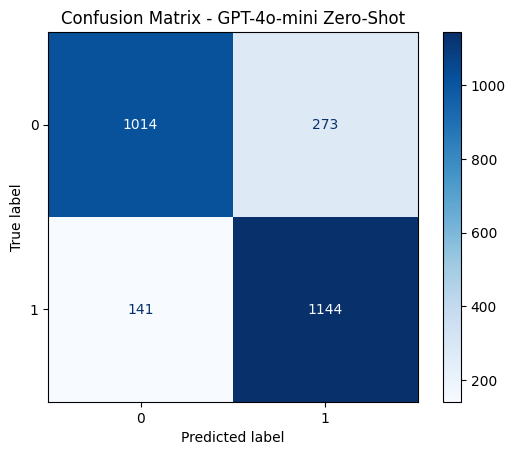

In [ ]:
# Confusion matrix for GPT-4o-mini Zero-Shot
cm_gpt4o_mini_zeroshot = confusion_matrix(y_true_gpt4o_mini_zero, y_pred_gpt4o_mini_zero)

# Display the matrix
disp_gpt4o_mini_zeroshot = ConfusionMatrixDisplay(confusion_matrix=cm_gpt4o_mini_zeroshot, display_labels=[0, 1])
disp_gpt4o_mini_zeroshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GPT-4o-mini Zero-Shot")
plt.show()

The GPT-4o-mini zero-shot model was used as the second baseline. Without any training examples, it achieved strong results: 0.84 accuracy, 0.81 precision, 0.89 recall, and 0.85 F1 score.

The confusion matrix indicates it correctly identified most ADR cases (true positives = 1144), while keeping false negatives (141) relatively low. However, it also produced 273 false positives.

These results show that GPT-4o-mini zero-shot is highly effective at identifying ADRs, with a slight tendency to overpredict in favor of recall.

### GPT-4o-mini Few-shot:

In [ ]:
# Few-shot examples for GPT-4o-mini:
# - 8 total examples (4 ADR = label 1, 4 Non-ADR = label 0)
# - Balanced between the two datasets (ADE and PsyTAR)
# - Used to guide the model in few-shot classification of ADR-related text
few_shot_examples = [
    {"text": "we report a case with chronic hepatitis c chc who developed sarcoidosis after the treatment by interferon alpha and ribavirin", "label": 1},
    {"text": "numerous studies suggest that ganciclovir has clinical efficacy against cytomegalovirus disease as well as an in vivo antiviral effect and that this agent reduces morbidity of serious cytomegalovirus infections in immunocompromised patients", "label": 0},
    {"text": "delusional parasitosis associated with phenelzine", "label": 1},
    {"text": "to our knowledge this is the first reported case in thailand", "label": 0},
    {"text": "lexapro before i got any fatter i stopped taking it and my metabolism is messed up", "label": 1},
    {"text": "zoloft no side effects no results", "label": 0},
    {"text": "cymbalta dry mouth and weightloss", "label": 1},
    {"text": "cymbalta i hate this drug", "label": 0},
]

In [ ]:
def few_shot_gpt_classify(text):
    """
    Uses GPT-4o-mini in a few-shot setting to classify whether a given sentence describes
    an Adverse Drug Reaction (ADR) or not.

    Returns:
        - 1 if the sentence describes an ADR
        - 0 if the sentence does not describe an ADR
        - None if the model response is invalid or an error occurs
    """

    # Format the few-shot examples into the prompt
    examples_text = "\n".join([
        f'Sentence: "{ex["text"]}"\nLabel: {ex["label"]}'
        for ex in few_shot_examples
    ])

    # Construct the full prompt including the input text
    prompt = f"""
You are a medical NLP classifier.

Below are examples of sentences and whether they describe an Adverse Drug Reaction (ADR):

{examples_text}

Now classify the following sentence:

Sentence: "{text}"
Label:
""".strip()

    # Send the prompt to GPT-4o-mini via Azure OpenAI
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                # System message sets the model's role
                {"role": "system", "content": "You classify sentences as describing an ADR (1) or not (0) based on few-shot examples."},
                # User message contains the task prompt
                {"role": "user", "content": prompt}
            ],
            max_tokens=5,        # Limit output to a short classification (0 or 1)
            temperature=0.0,     # Set temperature to 0 for deterministic output
        )

        output = response.choices[0].message.content.strip()
        return int(output) if output in ['0', '1'] else None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
# Run few-shot GPT classification on test set
df_test['gpt_fewshot_pred'] = [
    few_shot_gpt_classify(text) for text in tqdm(df_test['text'], desc="GPT-4o-mini Few-Shot Classification")
]

# Separate valid and invalid predictions
df_test_few = df_test.dropna(subset=['gpt_fewshot_pred'])
df_invalid = df_test[df_test['gpt_fewshot_pred'].isna()]

# Calculate evaluation metrics
y_true_gpt4o_mini_few = df_test_few['label']
y_pred_gpt4o_mini_few = df_test_few['gpt_fewshot_pred']

few_shot_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "GPT-4o-mini Few-Shot Score": [
        round(accuracy_score(y_true_gpt4o_mini_few, y_pred_gpt4o_mini_few), 2),
        round(precision_score(y_true_gpt4o_mini_few, y_pred_gpt4o_mini_few), 2),
        round(recall_score(y_true_gpt4o_mini_few, y_pred_gpt4o_mini_few), 2),
        round(f1_score(y_true_gpt4o_mini_few, y_pred_gpt4o_mini_few), 2)
    ]
})

# Show invalid prediction stats
total = len(df_test)
valid = len(df_test_few)
invalid = len(df_invalid)
percent_invalid = round((invalid / total) * 100, 2)

print(f"Total test samples:       {total}")
print(f"Valid model responses:    {valid}")
print(f"Invalid model responses:  {invalid} ({percent_invalid}%)")

# Display metrics table
few_shot_metrics_df

GPT-4o-mini Few-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Total test samples:       2573
Valid model responses:    2573
Invalid model responses:  0 (0.0%)


,Metric,GPT-4o-mini Few-Shot Score
0,Accuracy,0.85
1,Precision,0.85
2,Recall,0.85
3,F1 Score,0.85


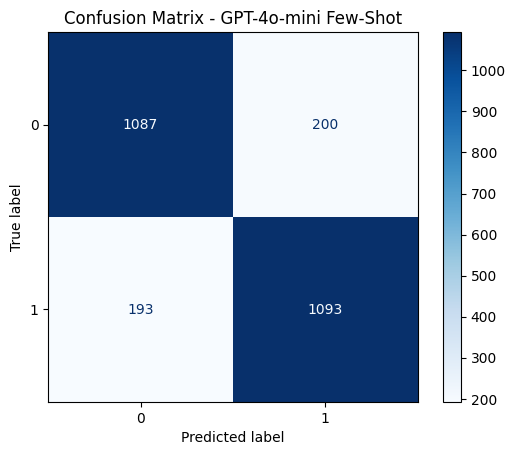

In [ ]:
# Confusion matrix for GPT-4o-mini Few-Shot
cm_gpt4o_mini_fewshot = confusion_matrix(y_true_gpt4o_mini_few, y_pred_gpt4o_mini_few)

# Display the matrix
disp_gpt4o_mini_fewshot = ConfusionMatrixDisplay(confusion_matrix=cm_gpt4o_mini_fewshot, display_labels=[0, 1])
disp_gpt4o_mini_fewshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GPT-4o-mini Few-Shot")
plt.show()

The GPT-4o-mini model performed strongly in the few-shot setting, using 8 labeled examples to guide classification. It achieved high and balanced scores across all metrics (accuracy, precision, recall, F1 = 0.85) with 100% valid outputs. The confusion matrix shows it correctly identified most ADR and non-ADR cases, making it a reliable model for our task.

## GPT-4o:

###GPT-4o Zero-shot:

In [ ]:
def zero_shot_gpt4o_classify(text):
    prompt = f"""
You are a medical NLP classifier.

Classify the following sentence as describing an Adverse Drug Reaction (ADR) or not.

Sentence:
"{text}"

Respond with only a single digit:
- Respond 1 if it describes an ADR.
- Respond 0 if it does NOT describe an ADR.
""".strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You classify medical sentences as ADR (1) or non-ADR (0)."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=5,
            temperature=0.0,
        )
        output = response.choices[0].message.content.strip()
        return int(output) if output in ['0', '1'] else None
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['gpt4o_zeroshot_pred'] = [
    zero_shot_gpt4o_classify(text) for text in tqdm(df_test['text'], desc="GPT-4o Zero-Shot Classification")
]

# Filter valid predictions
df_test_gpt4o = df_test.dropna(subset=['gpt4o_zeroshot_pred'])

# Report basic stats
total = len(df_test)
valid = len(df_test_gpt4o)
invalid = total - valid
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({round(invalid / total * 100, 2)}%)")

y_true_gpt4o_zero = df_test_gpt4o['label']
y_pred_gpt4o_zero = df_test_gpt4o['gpt4o_zeroshot_pred']

gpt4o_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "GPT-4o Zero-Shot Score": [
        round(accuracy_score(y_true_gpt4o_zero, y_pred_gpt4o_zero), 2),
        round(precision_score(y_true_gpt4o_zero, y_pred_gpt4o_zero), 2),
        round(recall_score(y_true_gpt4o_zero, y_pred_gpt4o_zero), 2),
        round(f1_score(y_true_gpt4o_zero, y_pred_gpt4o_zero), 2)
    ]
})

gpt4o_metrics_df

GPT-4o Zero-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': True, 'severity': 'medium'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
Total: 2573 | Valid: 2572 | Invalid: 1 (0.04%)


,Metric,GPT-4o Zero-Shot Score
0,Accuracy,0.81
1,Precision,0.75
2,Recall,0.95
3,F1 Score,0.84


In [ ]:
# The invalid line
df_test[df_test['gpt4o_zeroshot_pred'].isna()][['text', 'label']]

,text,label
12790,zoloft a week after the commencement of my tre...,1


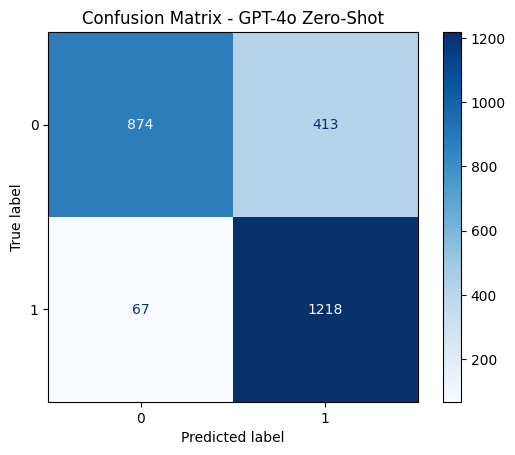

In [ ]:
# Confusion matrix for GPT-4o Zero-Shot
cm_gpt4o_zeroshot = confusion_matrix(y_true_gpt4o_zero, y_pred_gpt4o_zero)

# Display the matrix
disp_gpt4o_zeroshot = ConfusionMatrixDisplay(confusion_matrix=cm_gpt4o_zeroshot, display_labels=[0, 1])
disp_gpt4o_zeroshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GPT-4o Zero-Shot")
plt.show()

The GPT-4o zero-shot model showed strong performance in ADR detection, with an accuracy of 0.81 and a high recall of 0.95, meaning it was very good at catching true ADR cases. However, its precision was slightly lower (0.75), indicating a tendency to classify non-ADRs as ADRs. Only one response was invalid, showing high reliability.

The confusion matrix supports this, showing more false positives than false negatives.

Overall, GPT-4o Zero-Shot prioritized recall and performed well with minimal prompt errors.

###GPT-4o Few-shot:

In [ ]:
def few_shot_gpt4o_classify(text):
    examples_text = "\n".join([
        f'Sentence: "{ex["text"]}"\nLabel: {ex["label"]}'
        for ex in few_shot_examples
    ])

    prompt = f"""
You are a medical NLP classifier.

Below are examples of sentences and whether they describe an Adverse Drug Reaction (ADR):

{examples_text}

Now classify the following sentence:

Sentence: "{text}"
Label:
""".strip()

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You classify sentences as ADR (1) or non-ADR (0) based on few-shot examples."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=5,
            temperature=0.0,
        )
        output = response.choices[0].message.content.strip()
        return int(output) if output in ['0', '1'] else None
    except Exception as e:
        print(f"Error: {e}")
        return None

In [ ]:
df_test['gpt4o_fewshot_pred'] = [
    few_shot_gpt4o_classify(text) for text in tqdm(df_test['text'], desc="GPT-4o Few-Shot Classification")
]

# Filter valid predictions
df_test_gpt4o_few = df_test.dropna(subset=['gpt4o_fewshot_pred'])

# Report stats
total = len(df_test)
valid = len(df_test_gpt4o_few)
invalid = total - valid
print(f"Total: {total} | Valid: {valid} | Invalid: {invalid} ({round(invalid / total * 100, 2)}%)")

y_true_gpt4o_few = df_test_gpt4o_few['label']
y_pred_gpt4o_few = df_test_gpt4o_few['gpt4o_fewshot_pred']

gpt4o_fewshot_metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "GPT-4o Few-Shot Score": [
        round(accuracy_score(y_true_gpt4o_few, y_pred_gpt4o_few), 2),
        round(precision_score(y_true_gpt4o_few, y_pred_gpt4o_few), 2),
        round(recall_score(y_true_gpt4o_few, y_pred_gpt4o_few), 2),
        round(f1_score(y_true_gpt4o_few, y_pred_gpt4o_few), 2)
    ]
})

gpt4o_fewshot_metrics_df

GPT-4o Few-Shot Classification:   0%|          | 0/2573 [00:00<?, ?it/s]

Total: 2573 | Valid: 2573 | Invalid: 0 (0.0%)


,Metric,GPT-4o Few-Shot Score
0,Accuracy,0.84
1,Precision,0.81
2,Recall,0.89
3,F1 Score,0.85


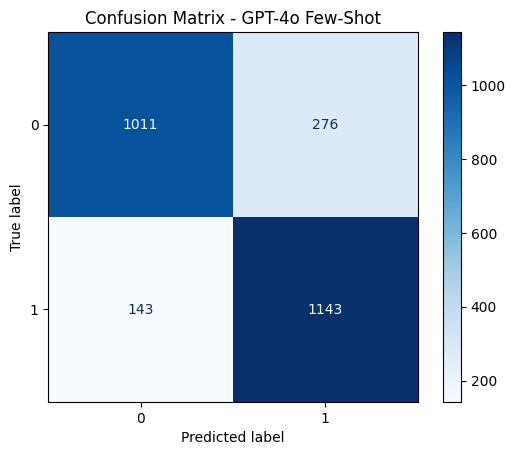

In [ ]:
# Confusion matrix for GPT-4o Few-Shot
cm_gpt4o_fewshot = confusion_matrix(y_true_gpt4o_few, y_pred_gpt4o_few)

# Display the matrix
disp_gpt4o_fewshot = ConfusionMatrixDisplay(confusion_matrix=cm_gpt4o_fewshot, display_labels=[0, 1])
disp_gpt4o_fewshot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GPT-4o Few-Shot")
plt.show()

The GPT-4o few-shot model achieved strong and balanced performance with 0% invalid predictions. It reached an accuracy of 0.84, precision of 0.81, recall of 0.89, and F1 score of 0.85. The confusion matrix shows 1,143 true positives and 143 false negatives, indicating good sensitivity, while 276 false positives slightly affected precision.

# Evaluation Results for All Models:

## Embeddings + BOW:

In [ ]:
model_predictions_test = {
    "BoW + Naive Bayes": (y_test, y_test_bow_pred),
    "SBERT + LR": (y_test, y_test_sbert_pred),
    "BioBERT + LR": (y_test, y_test_pred_bio),
    "InstructorXL + LR": (y_test, y_test_pred_inst),
}

# Helper function to compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "Accuracy": round(accuracy_score(y_true, y_pred), 2),
        "Precision": round(precision_score(y_true, y_pred), 2),
        "Recall": round(recall_score(y_true, y_pred), 2),
        "F1 Score": round(f1_score(y_true, y_pred), 2),
    }

# Create DataFrame of test results only
test_results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for model_name, (y_true, y_pred) in model_predictions_test.items():
    metrics = compute_metrics(y_true, y_pred)
    test_results["Model"].append(model_name)
    for metric_name, value in metrics.items():
        test_results[metric_name].append(value)

# Convert to DataFrame
Embedding_and_baseline_results = pd.DataFrame(test_results)
Embedding_and_baseline_results

,Model,Accuracy,Precision,Recall,F1 Score
0,BoW + Naive Bayes,0.76,0.73,0.81,0.77
1,SBERT + LR,0.78,0.77,0.80,0.78
2,BioBERT + LR,0.82,0.82,0.82,0.82
3,InstructorXL + LR,0.81,0.81,0.81,0.81


In [ ]:
# Save the embeddings + BoW results DataFrame to CSV
embedding_results_path = "/content/drive/MyDrive/NLP Project/NLP Project - Datasets/embeddings_and_baseline_results.csv"
Embedding_and_baseline_results.to_csv(embedding_results_path, index=False)

embedding_results_path

'/content/drive/MyDrive/NLP Project/NLP Project - Datasets/embeddings_and_baseline_results.csv'

## LLMs:

In [ ]:
# Collect all metrics from already created DataFrames
llm_tables = {
    "Phi-4-mini Zero-Shot": phi4_metrics_df,
    "Phi-4-mini Few-Shot": phi4_fewshot_df,
    "LLaMA Zero-Shot": llama_metrics,
    "LLaMA Few-Shot": llama_few_metrics,
    "GPT-4o-mini Zero-Shot": metrics_df,
    "GPT-4o-mini Few-Shot": few_shot_metrics_df,
    "GPT-4o Zero-Shot": gpt4o_metrics_df,
    "GPT-4o Few-Shot": gpt4o_fewshot_metrics_df
}

# Construct final DataFrame: models as rows, metrics as columns
rows = []
for model_name, df in llm_tables.items():
    metrics = df[df.columns[1]].values  # Second column contains the scores
    rows.append([model_name] + list(metrics))

llm_results = pd.DataFrame(rows, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Display the table
llm_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Phi-4-mini Zero-Shot,0.77,0.73,0.87,0.79
1,Phi-4-mini Few-Shot,0.73,0.75,0.69,0.72
2,LLaMA Zero-Shot,0.71,0.73,0.66,0.70
3,LLaMA Few-Shot,0.60,0.74,0.36,0.49
4,GPT-4o-mini Zero-Shot,0.84,0.81,0.89,0.85
5,GPT-4o-mini Few-Shot,0.85,0.85,0.85,0.85
6,GPT-4o Zero-Shot,0.81,0.75,0.95,0.84
7,GPT-4o Few-Shot,0.84,0.81,0.89,0.85


In [ ]:
# Save the embeddings + BoW results DataFrame to CSV
llm_results_path = "/content/drive/MyDrive/NLP Project/NLP Project - Datasets/llm_results.csv"
llm_results.to_csv(llm_results_path, index=False)

llm_results_path

'/content/drive/MyDrive/NLP Project/NLP Project - Datasets/llm_results.csv'

In [ ]:
# Combine the embeddings results with LLM results
all_models_results = pd.concat([Embedding_and_baseline_results, llm_results], axis=0, ignore_index=True)
all_models_results

,Model,Accuracy,Precision,Recall,F1 Score
0,BoW + Naive Bayes,0.76,0.73,0.81,0.77
1,SBERT + LR,0.78,0.77,0.80,0.78
2,BioBERT + LR,0.82,0.82,0.82,0.82
3,InstructorXL + LR,0.81,0.81,0.81,0.81
4,Phi-4-mini Zero-Shot,0.77,0.73,0.87,0.79
5,Phi-4-mini Few-Shot,0.73,0.75,0.69,0.72
6,LLaMA Zero-Shot,0.71,0.73,0.66,0.70
7,LLaMA Few-Shot,0.60,0.74,0.36,0.49
8,GPT-4o-mini Zero-Shot,0.84,0.81,0.89,0.85
9,GPT-4o-mini Few-Shot,0.85,0.85,0.85,0.85


In [ ]:
# Save the embeddings + BoW results DataFrame to CSV
all_models_evaluation_path = "/content/drive/MyDrive/NLP Project/NLP Project - Datasets/overall_results.csv"
all_models_results.to_csv(all_models_evaluation_path, index=False)

all_models_evaluation_path

'/content/drive/MyDrive/NLP Project/NLP Project - Datasets/overall_results.csv'

## Visualization:

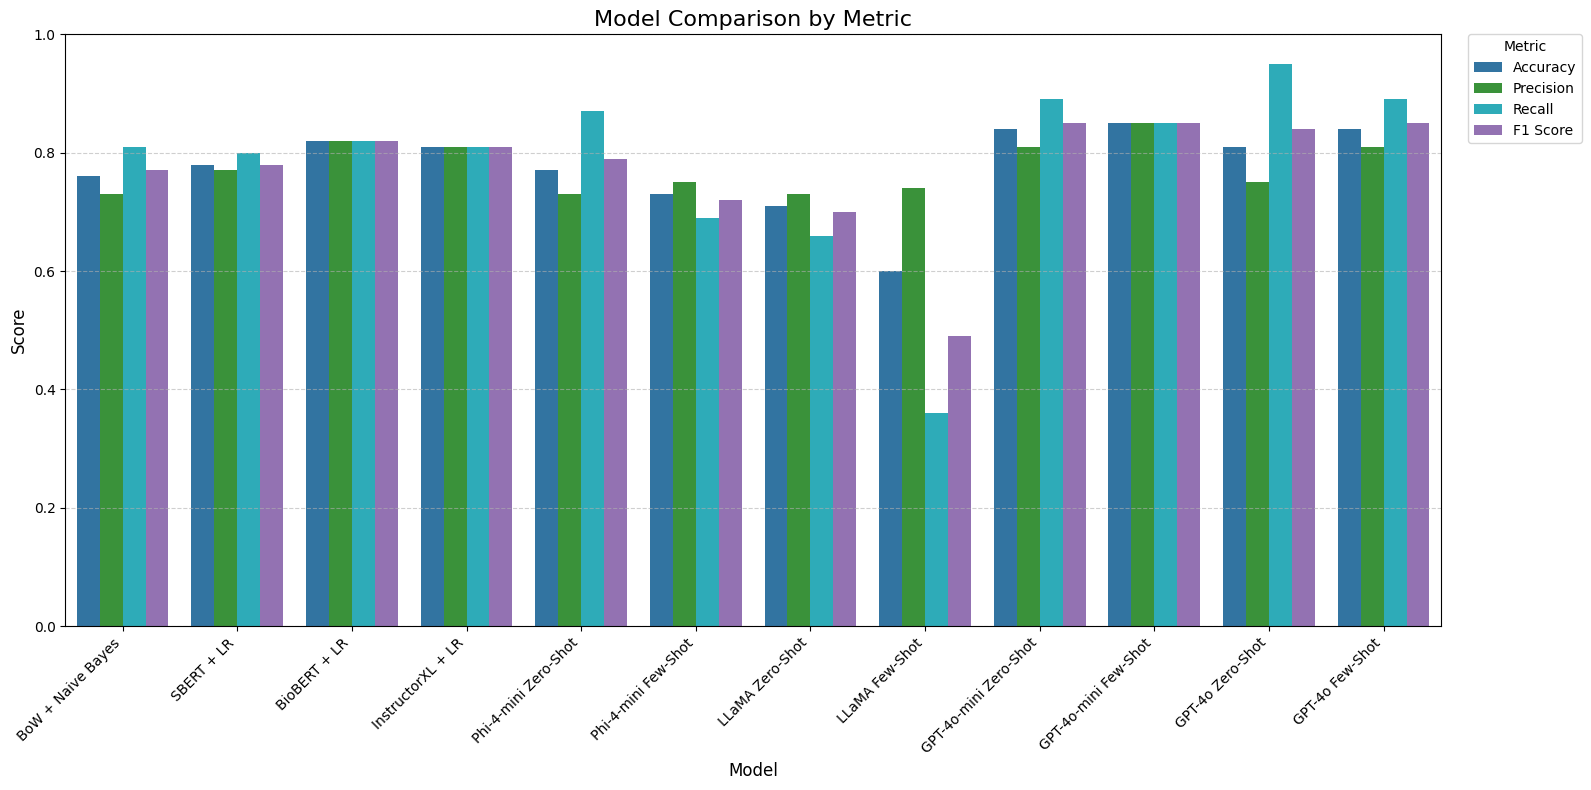

In [ ]:
# Melt the DataFrame to long format
df_melted = all_models_results.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    var_name='Metric',
    value_name='Score'
)

# Our color palette
custom_palette = {
    'Accuracy': '#1f77b4',   # blue
    'Precision': '#2ca02c',  # green
    'Recall': '#17becf',     # teal
    'F1 Score': '#9467bd'    # purple
}

# Create the grouped bar plot
plt.figure(figsize=(16, 8))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette=custom_palette)

# Customize the plot
plt.title("Model Comparison by Metric", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Move legend outside the plot
plt.legend(
    title="Metric",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=10
)

plt.tight_layout()
plt.show()

# Results and Insights:

The GPT-4o and GPT-4o-mini models delivered the strongest results overall, with both zero-shot and few-shot setups reaching an F1 score of 0.85. Interestingly, few-shot examples didn’t noticeably improve their performance, since they already performed very well in zero-shot mode — showing strong generalization and instruction-following abilities. Among all models, GPT-4o Zero-Shot emerged as the best option, achieving the highest recall (0.95) and maintaining strong accuracy and precision, all without requiring prompt tuning or additional examples.

Embedding-based models also performed well: BioBERT + Logistic Regression reached an F1 of 0.82, slightly outperforming InstructorXL (0.81) and SBERT (0.78). Even the BoW + Naive Bayes baseline was decent (F1 = 0.77), proving that traditional models can still serve as reliable reference points.

On the other hand, LLaMA-3.2B struggled with few-shot prompting — its F1 dropped to 0.49, mainly due to a big drop in recall (0.36). Phi-4-mini showed a similar pattern, performing better in zero-shot than few-shot mode. These results highlight that few-shot prompting doesn’t work the same across all models. We initially tried to use the same number of few-shot examples for fairness, but it quickly became clear that smaller or less instruction-tuned models like LLaMA and Phi-4 were more sensitive to prompt design. We ended up tuning the number of examples per model to get decent results, showing that more examples don’t always help.

In addition, we found that the prompt format itself, not just the examples, can significantly affect the precision–recall tradeoff. In some cases, slight changes to the wording or structure of the instruction prompt caused shifts in model behavior, either increasing recall at the cost of precision or vice versa. This reinforces how sensitive LLMs can be to prompt design, and how important it is to test and iterate.

For real-world ADR detection, where missing a case is more harmful than flagging too many, models with high recall — especially in zero-shot mode — are ideal. In our case, GPT-4o Zero-Shot delivered the best balance of reliability, simplicity, and performance.